In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095447 sha256=a66a685ef7e72c95a64ef3420770d697f59c878ed11c01abcf1a98e0bee454c4
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
import math
from collections import defaultdict
import csv
from sklearn.metrics import ndcg_score
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval

In [62]:
import plotly.express as px
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise import NormalPredictor
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

## Task A : Data selection and Preprocessing

In [8]:
movies_data = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')
ratings_data = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
tags_data = pd.read_csv('/content/drive/MyDrive/ml-latest-small/tags.csv')

In [9]:
df_merged = pd.merge(ratings_data, movies_data, on='movieId' , how='left')
df_merged = df_merged.drop('title', axis=1)
df_merged.head(5)

,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Comedy|Romance
2,1,6,4.0,964982224,Action|Crime|Thriller
3,1,47,5.0,964983815,Mystery|Thriller
4,1,50,5.0,964982931,Crime|Mystery|Thriller


In [10]:
df_merged['genres'] = df_merged['genres'].str.split('|')

In [11]:
df_merged.head()

,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,3,4.0,964981247,"[Comedy, Romance]"
2,1,6,4.0,964982224,"[Action, Crime, Thriller]"
3,1,47,5.0,964983815,"[Mystery, Thriller]"
4,1,50,5.0,964982931,"[Crime, Mystery, Thriller]"


In [12]:
tags_data['tag'] = tags_data['tag'].str.split('|')
tags_data.drop('timestamp', axis=1, inplace=True)

In [13]:
tags_data = tags_data.groupby(['userId','movieId'])['tag'].apply(lambda x: ','.join(x.astype(str))).reset_index()
tags_data.head()

,userId,movieId,tag
0,2,60756,"['funny'],['Highly quotable'],['will ferrell']"
1,2,89774,"['Boxing story'],['MMA'],['Tom Hardy']"
2,2,106782,"['drugs'],['Leonardo DiCaprio'],['Martin Scors..."
3,7,48516,['way too long']
4,18,431,"['Al Pacino'],['gangster'],['mafia']"


In [14]:
df_merged = pd.merge(df_merged, tags_data, on=['userId','movieId'], how='left')

In [15]:
df_merged['tag'] = df_merged['tag'].apply(lambda k: k if isinstance(k, list) else [])
df_merged['genres'] = df_merged['genres'].apply(lambda k: k if isinstance(k, list) else [])

In [16]:
training_data, testing_data = train_test_split(df_merged, test_size=0.2, stratify=df_merged.userId)

In [17]:
training_data = training_data.sort_values(['userId', 'movieId'])

In [18]:
testing_data = testing_data.sort_values(['userId','movieId'])

In [19]:
training_data.to_csv('training_data.csv', index = False)
testing_data.to_csv('testing_data.csv', index = False)

In [20]:
movies_data['genres'] = movies_data['genres'].str.split('|')
movies_data['genres'] = movies_data['genres'].apply(lambda k: k if isinstance(k, list) else [])
movies_data.to_csv('movies.csv', index = False)

# Popularity Based Model

In [21]:
movies_5000 = pd.read_csv('/content/drive/MyDrive/tmdb_5000/tmdb_5000_movies.csv')
credits_5000 = pd.read_csv('/content/drive/MyDrive/tmdb_5000/tmdb_5000_credits.csv')

In [22]:
movies_5000.sort_values(by='popularity', ascending=False)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,211672,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,Minions,"Minions Stuart, Kevin and Bob are recruited by...",875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,1156730962,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Before Gru, they had a history of bad bosses",Minions,6.4,4571
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,157336,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Interstellar,Interstellar chronicles the adventures of a gr...,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,675120017,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mankind was born on Earth. It was never meant ...,Interstellar,8.1,10867
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,293660,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,Deadpool,Deadpool tells the origin story of former Spec...,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,783112979,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Witness the beginning of a happy ending,Deadpool,7.4,10995
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,118340,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,773328629,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,All heroes start somewhere.,Guardians of the Galaxy,7.9,9742
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,76341,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,Mad Max: Fury Road,An apocalyptic story set in the furthest reach...,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,378858340,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,What a Lovely Day.,Mad Max: Fury Road,7.2,9427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,0,"[{""id"": 27, ""name"": ""Horror""}]",NaN,426067,[],en,Midnight Cabaret,A Broadway producer puts on a play with a Devi...,0.001389,[],[],1990-01-01,0,94.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The hot spot where Satan's waitin'.,Midnight Cabaret,0.0,0
4118,0,[],NaN,325140,[],en,Hum To Mohabbat Karega,"Raju, a waiter, is in love with the famous TV ...",0.001186,[],[],2000-05-26,0,0.0,[],Released,NaN,Hum To Mohabbat Karega,0.0,0
4727,0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",NaN,65448,"[{""id"": 378, ""name"": ""prison""}, {""id"": 209476,...",en,Penitentiary,A hitchhiker named Martel Gordone gets in a fi...,0.001117,[],[],1979-12-01,0,99.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"There's only one way out, and 100 fools stand ...",Penitentiary,4.9,8
3361,0,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 28, ""nam...",NaN,77156,[],en,Alien Zone,A man who is having an affair with a married w...,0.000372,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1978-11-22,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""En

In [23]:
genres_dictionary = {'Adventure': 0,
 'Animation': 1,
 'Children': 2,
 'Comedy': 3,
 'Fantasy': 4,
 'Romance': 5,
 'Drama': 6,
 'Action': 7,
 'Crime': 8,
 'Thriller': 9,
 'Horror': 10,
 'Mystery': 11,
 'Sci-Fi': 12,
 'War': 13,
 'Musical': 14,
 'Documentary': 15,
 'IMAX': 16,
 'Western': 17,
 'Film-Noir': 18,
 '(no genres listed)': 19}

In [24]:
def func_popularity_by_genre(genre):
    mask = movies_5000.genres.apply(lambda t: genre in t)
    popularity_val = movies_5000[mask]
    popularity_val = popularity_val.sort_values(by='popularity', ascending=False)
    return popularity_val

In [25]:
func_popularity_by_genre('Animation')[['title', 'popularity']].head(10)

,title,popularity
546,Minions,875.581305
88,Big Hero 6,203.734590
124,Frozen,165.125366
506,Despicable Me 2,136.886704
77,Inside Out,128.655964
55,Brave,125.114374
2294,Spirited Away,118.968562
614,Despicable Me,113.858273
231,"Monsters, Inc.",106.815545
160,How to Train Your Dragon 2,100.213910


In [26]:
func_popularity_by_genre('Action')[['title', 'popularity']].head(10)

,title,popularity
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
88,Big Hero 6,203.734590
108,Terminator Genisys,202.042635
26,Captain America: Civil War,198.372395
65,The Dark Knight,187.322927


In [27]:
V = movies_5000[movies_5000['vote_count'].notnull()]['vote_count'].astype('int')
R = movies_5000[movies_5000['vote_average'].notnull()]['vote_average'].astype('int')
C = R.mean()
m = V.quantile(0.95)

In [28]:
def func_weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(v+m) * C)

In [29]:
movies_5000['wr'] = movies_5000.apply(func_weighted_rating, axis=1)

In [30]:
def func_popularity_by_wr(genre):
    mask = movies_5000.genres.apply(lambda t: genre in t)
    popularity_val = movies_5000[mask]
    popularity_val = popularity_val.sort_values(by='wr', ascending=False)
    return popularity_val

In [31]:
func_popularity_by_wr('Animation')[['title', 'wr', 'popularity']].head(10)

,title,wr,popularity
77,Inside Out,7.256609,128.655964
494,The Lion King,7.152037,90.457886
2294,Spirited Away,7.130169,118.968562
57,WALL·E,7.100727,66.390712
88,Big Hero 6,7.088458,203.734590
66,Up,7.071909,92.201962
328,Finding Nemo,6.953823,85.688789
1541,Toy Story,6.950900,73.640445
231,"Monsters, Inc.",6.878463,106.815545
42,Toy Story 3,6.824805,59.995418


In [32]:
func_popularity_by_wr('Action')[['title', 'wr', 'popularity']].head(10)

,title,wr,popularity
65,The Dark Knight,7.685113,187.322927
96,Inception,7.656878,167.583710
329,The Lord of the Rings: The Return of the King,7.429908,123.630332
262,The Lord of the Rings: The Fellowship of the Ring,7.392365,138.049577
94,Guardians of the Galaxy,7.365448,481.098624
1990,The Empire Strikes Back,7.331672,78.517830
2912,Star Wars,7.330069,126.393695
634,The Matrix,7.328089,104.309993
330,The Lord of the Rings: The Two Towers,7.322066,106.914973
571,Inglourious Basterds,7.178513,72.595961


# Content Based Recommendation

In [33]:
movies_content = pd.read_csv("movies.csv", converters={"genres": literal_eval})

In [37]:
train_data_content = pd.read_csv("training_data.csv", converters={"genres": literal_eval, "tag": literal_eval})

In [38]:
unique_genre = movies_content['genres'].explode().unique()
dist_of_genre = train_data_content['genres'].explode().value_counts()
genre_dict = {k: v for v, k in enumerate(unique_genre)}

In [39]:

fig = px.pie(dist_of_genre, values = dist_of_genre.values, names = dist_of_genre.keys(), title='Genre distribution')
fig.show()

In [40]:
movies_content['movie_vector'] = ""
for i, row in movies_content.iterrows():
    genres = row.genres
    movie_vector = np.zeros(len(genre_dict))
    for g in genres:
        movie_vector[genre_dict[g]] = 1
    movies_content.at[i, 'movie_vector'] = movie_vector
movies_content.to_csv("movie_vector.csv")

In [42]:
user_ids = train_data_content['userId'].unique()
user_info = pd.DataFrame(columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])              
for user_id in user_ids:
    user_ratings = train_data_content[(train_data_content['userId'] == user_id)]
    user_vector = np.zeros(len(genre_dict))
    count_vector = np.zeros(len(genre_dict))
    user_avg_rating = 0
    movies_rated_count = 0
    for _, row in user_ratings.iterrows():
        user_avg_rating += row.rating 
        movies_rated_count += 1
        genres = row.genres
        user_movie_vector = np.zeros(len(genre_dict))
        for g in genres:
            user_movie_vector[genre_dict[g]] = 1
            count_vector[genre_dict[g]] += 1
        user_vector += user_movie_vector*row.rating
    count_vector = np.where(count_vector==0, 1, count_vector)
    user_vector = np.divide(user_vector, count_vector)
    user_avg_rating /= movies_rated_count
    row_df = pd.DataFrame([[user_id, user_vector, user_avg_rating, movies_rated_count]], 
                          columns=['userId', 'user_vector', 'avg_rating', 'num_movies_rated'])
    user_info = pd.concat([user_info, row_df], ignore_index=True)

In [43]:
user_info.to_csv("user_info.csv")

In [50]:
ratings_test_data = pd.read_csv("testing_data.csv", converters={"genres": literal_eval, "tag": literal_eval}) 

In [51]:
genres_list = user_ratings[user_ratings['movieId']==16]

In [52]:
genres_list = user_ratings[user_ratings['movieId']==16].genres.values[0]
vector = np.zeros(len(genre_dict))
for g in genres:
    vector[genre_dict[g]] = 1

In [53]:
user_info[user_info['userId']==1].user_vector[0]

array([4.45714286, 4.75      , 4.6       , 4.21875   , 4.27027027,
       4.35      , 4.52542373, 4.35616438, 4.25714286, 4.14285714,
       3.33333333, 3.92857143, 4.25925926, 4.57894737, 4.61111111,
       0.        , 0.        , 4.5       , 0.        , 0.        ])

In [54]:
y = vector*user_info[user_info['userId']==1].user_vector[0]
np.nanmean(np.where(y!=0,y,np.nan)) 

4.391283292978208

In [56]:
algo_predictions_df = pd.DataFrame(columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
for ind, row in ratings_test_data.iterrows():
    userId = row['userId']
    movieId = row['movieId']
    og_rating = row['rating']
    try:
        user_vector = user_info[user_info['userId'] == int(userId)].user_vector.values[0]
        movie_vector = movies_content[movies_content['movieId'] == int(movieId)].movie_vector.values[0]
        predicted_rating = user_vector*movie_vector
        if predicted_rating.any():
            predicted_rating = np.nanmean(np.where(predicted_rating!=0, predicted_rating, np.nan)) 
        else:
            predicted_rating = 0
        row_df = pd.DataFrame([[userId, movieId, user_vector, movie_vector, og_rating, predicted_rating]], 
                    columns=['userId', 'movieId', 'user_vector', 'movie_vector', 'og_rating', 'pred_rating'])
        algo_predictions_df = pd.concat([algo_predictions_df, row_df], ignore_index=True)
    except:
        print("User not found: ", userId)

In [63]:
rmse_value = ((algo_predictions_df.og_rating - algo_predictions_df.pred_rating) ** 2).mean() ** .5
print('rmse:',rmse_value)

rmse: 0.9282822878123123


In [64]:
mae_value = (((algo_predictions_df.og_rating - algo_predictions_df.pred_rating) ** 2) ** .5).mean()
print('mae:',mae_value)

mae: 0.7169519139019701


# Collaborative FIltering

In [60]:
data_1m = Dataset.load_builtin('ml-1m')

Dataset ml-1m could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /root/.surprise_data/ml-1m


In [65]:
training_dataset_1m, testing_dataset_1m = train_test_split(data_1m, test_size=.20)

In [66]:
def func_accuracy(algorithm, train, test):
  algorithm.fit(train)
  predictions = algorithm.test(test)
  accuracy.rmse(predictions)
  accuracy.mae(predictions)
  return

In [67]:
simulation_options = {'name': 'cosine',
               'user_based': False
               }
algorithm = KNNBaseline(sim_options=simulation_options)
algorithm.fit(training_dataset_1m)
predictions = algorithm.test(testing_dataset_1m)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8931
MAE:  0.7016


0.7016140732435465

In [68]:
simulation_options = {'name': 'cosine'}
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9007
MAE:  0.7112


In [70]:
simulation_options = {'name': 'msd',
               'user_based': False
               }
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8843
MAE:  0.6936


In [ ]:
simulation_options = {'name': 'msd'}
algo = KNNBaseline(sim_options=simulation_options)
func_accuracy(algo, training_dataset_1m, testing_dataset_1m)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
simulation_options = {'name': 'pearson',
               'user_based': False
               }
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
simulation_options = {'name': 'pearson'}
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
simulation_options = {'name': 'pearson_baseline',
               'user_based': False
               }
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
simulation_options = {'name': 'pearson_baseline',
               'user_based': False
               }
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
simulation_options = {'name': 'pearson_baseline'}
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
simulation_options = {'name': 'pearson_baseline'}
algorithm = KNNBaseline(sim_options=simulation_options)
func_accuracy(algorithm, training_dataset_1m, testing_dataset_1m)

In [ ]:
def func_process_data(train, test):
    reader = Reader(rating_scale=(0, 5))
    training_set = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
    testing_set = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)
    training_set = training_set.construct_trainset(training_set.raw_ratings)
    testing_set = testing_set.construct_testset(testing_set.raw_ratings)
    return training_set, testing_set

In [ ]:
training_data_csv = 'training_data.csv'
testing_data_csv = 'testing_data.csv'
df1 = pd.read_csv(training_data_csv)
df2 = pd.read_csv(testing_data_csv)
trainset, testset = func_process_data(df1, df2)

In [ ]:
def accuracy_function(algo, training_set, testing_set):
  algo.fit(training_set)
  predictions = algo.test(testing_set)
  rmse = accuracy.rmse(predictions)
  mae = accuracy.mae(predictions)
  return rmse, mae, predictions

In [ ]:
print('Using ALS')
para = {'method': 'als', 'n_epochs': 5, 'reg_u': 12, 'reg_i': 5}
algo = BaselineOnly(bsl_options=para)
test_rmse, test_mae, test_pred = accuracy_function(algo, trainset, testset)

Using ALS
Estimating biases using als...
RMSE: 0.8705
MAE:  0.6719


In [ ]:
print('Using SGD')
algo = BaselineOnly()
test_rmse, test_mae, test_pred = accuracy_function(algo, trainset, testset)

Using SGD
Estimating biases using als...
RMSE: 0.8761
MAE:  0.6779


In [ ]:
print("KNN Baseline")
algo = KNNBaseline()
test_knn_rmse, test_knn_mae, test_knn_pred = accuracy_function(algo, trainset, testset)

KNN Baseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8767
MAE:  0.6713


In [ ]:
print("SlopeOne")
algo = SlopeOne()
test_slopeone_rmse, test_slopeone_mae, test_slopeone_pred = accuracy_function(algo, trainset, testset)

SlopeOne
RMSE: 0.9062
MAE:  0.6918


In [ ]:
print("BaselineOnly")
algo = BaselineOnly()
test_base_rmse, test_base_mae, test_base_pred  = accuracy_function(algo, trainset, testset)

BaselineOnly
Estimating biases using als...
RMSE: 0.8761
MAE:  0.6779


In [ ]:
print("SVD")
algo = SVD()
test_svd_rmse, test_svd_mae, test_svd_pred  = accuracy_function(algo, trainset, testset)

SVD
RMSE: 0.8807
MAE:  0.6797


In [ ]:
print("SVDpp")
algo = SVDpp()
test_svdpp_rmse, test_svdpp_mae, test_svdpp_pred = accuracy_function(algo, trainset, testset)

SVDpp
RMSE: 0.8711
MAE:  0.6687


In [ ]:
print("NMF")
algo = NMF()
test_nmf_rmse, test_nmf_mae, test_nmf_pred = accuracy_function(algo, trainset, testset)

NMF
RMSE: 0.9239
MAE:  0.7076


In [ ]:
print("KNN OG")
algo = KNNBasic()
test_knnog_rmse, test_knnog_mae, test_knnog_pred = accuracy_function(algo, trainset, testset)

KNN OG
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9491
MAE:  0.7303


In [ ]:
test_prediction = pd.DataFrame(columns= ['uid', 'iid', 'og_rating', 'svd_rating', 'knn_rating', 'svdpp_rating', 'slopeone_rating', 'baseline_rating','nmf_rating', 'knn_rating'])

In [ ]:
from tqdm import tqdm
for i in tqdm(range(len(test_base_pred))): 
  svd = test_svd_pred[i]
  knn = test_knn_pred[i]
  svdpp = test_svdpp_pred[i]
  nmf = test_nmf_pred[i]
  slopeone = test_slopeone_pred[i]
  baseline = test_base_pred[i]
  knn = test_knnog_pred[i]
  df = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, svd.est, knn.est, svdpp.est, slopeone.est, baseline.est, nmf.est, knn.est]], columns=['uid', 'iid', 'og_rating', 'svd_rating', 'knn_rating', 'svdpp_rating', 'slopeone_rating','baseline_rating','nmf_rating', 'knn_rating'])
  test_prediction = pd.concat([df, test_prediction], ignore_index=True)

100%|██████████| 20168/20168 [00:31<00:00, 648.97it/s]


In [ ]:
test_prediction

,uid,iid,og_rating,svd_rating,knn_rating,svdpp_rating,slopeone_rating,baseline_rating,nmf_rating,knn_rating
0,610,164179,5.0,4.106711,4.092928,4.182290,4.138687,3.945412,3.684582,4.092928
1,610,158721,3.5,3.633829,3.502839,3.610507,3.502839,3.631497,3.502839,3.502839
2,610,150401,3.0,3.574861,3.000000,3.748081,3.641169,3.641194,2.716204,3.000000
3,610,147662,3.0,3.633829,3.502839,3.610507,3.502839,3.631497,3.502839,3.502839
4,610,142366,3.0,3.633829,3.502839,3.610507,3.502839,3.631497,3.502839,3.502839
...,...,...,...,...,...,...,...,...,...,...
49230,1,296,3.0,4.726579,4.291256,5.000000,5.000000,4.920596,4.831163,4.291256
49231,1,223,3.0,4.977664,3.971825,4.700759,4.741154,4.673196,5.000000,3.971825
49232,1,70,3.0,4.190515,3.701073,4.301594,4.619477,4.380599,4.723406,3.701073
49233,1,6,4.0,4.530490,4.154334,4.710026,4.690273,4.665927,5.000000,4.154334


In [ ]:
test_prediction.to_csv('test_prediction.csv')

# Combined Model (SVD + Colabrative Filtering)

In [ ]:
prediction = pd.read_csv('test_prediction.csv')
mean_value=prediction['nmf_rating'].mean()

prediction['nmf_rating'].fillna(value=mean_value, inplace=True)

In [ ]:
T = prediction.shape[0]
'''svd_wt = 0.05
knn_wt = 0.6
svdpp_wt = 0.4
slopeone_wt = 0
baseline_wt = 0'''
svd_wt = 0 #0.05
knn_wt = 0.5
svdpp_wt = 0.25
nmf_wt = 0.25
slopeone_wt = 0
baseline_wt = 0


In [ ]:
rmse = ((prediction.og_rating - prediction.knn_rating) ** 2).mean() ** .5
print("RMSE", rmse)
mae = (((prediction.og_rating - prediction.knn_rating) ** 2) ** .5).mean()
print("MAE", mae)

RMSE 0.8762772727375279
MAE 0.6733021328178305


In [ ]:
rmse = ((prediction.og_rating - prediction.svdpp_rating) ** 2).mean() ** .5
print("RMSE", rmse)
mae = (((prediction.og_rating - prediction.svdpp_rating) ** 2) ** .5).mean()
print("MAE", mae)

RMSE 0.8668473985469755
MAE 0.6640851256410752


In [ ]:
rmse = ((prediction.og_rating - prediction.nmf_rating) ** 2).mean() ** .5
print("RMSE", rmse)
mae = (((prediction.og_rating - prediction.nmf_rating) ** 2) ** .5).mean()
print("MAE", mae)

RMSE 0.9243150896191162
MAE 0.7103065629525892


In [ ]:
sqr_sum = 0
abs_sum = 0

for ind, row in prediction.iterrows():
  org_r = row['og_rating']
  pred_r = svd_wt*row['svd_rating'] + knn_wt*row['knn_rating'] + svdpp_wt*row['svdpp_rating'] + slopeone_wt*row['slopeone_rating'] + baseline_wt*row['baseline_rating'] + nmf_wt*row['nmf_rating']
  diff = np.abs(org_r - pred_r)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8854073480824385
MAE 0.6817002283015076


# Item Recommendation

In [ ]:
def process_data(train, test):
    reader = Reader(rating_scale=(0, 5))
    training_set = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)
    testing_set = Dataset.load_from_df(test[['userId', 'movieId', 'rating']], reader)
    training_set = training_set.construct_trainset(training_set.raw_ratings)
    testing_set = testing_set.construct_testset(testing_set.raw_ratings)
    return training_set, testing_set

In [ ]:
training_data_csv = 'training_data.csv'
testing_data_csv = 'testing_data.csv'
df1 = pd.read_csv(training_data_csv)
df2 = pd.read_csv(testing_data_csv)
trainset, testset = process_data(df1, df2)

In [ ]:
def get_top_n(predictions, n):
    top_n = defaultdict(list)
    org_ratings = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        org_ratings[uid].append((iid, true_r))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n, org_ratings

In [ ]:
def dcg_at_k(scores):
    return scores[0] + sum(sc/math.log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores) + 1)))
def ndcg_at_k(scores):
    idcg = dcg_at_k(sorted(scores, reverse=True))
    return (dcg_at_k(scores)/idcg) if idcg > 0.0 else 0.0

In [ ]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    precision = (sum(prec for prec in precisions.values()) / len(precisions))
    recall = (sum(rec for rec in recalls.values()) / len(recalls))
    return precision, recall

In [ ]:
def recommendation(algo, trainset, testset):
  start_fit = time.time()
  algo.fit(trainset)
  end_fit = time.time()
  fit_time = end_fit - start_fit
  start_test = time.time()
  test_predictions = algo.test(testset)
  end_test = time.time()
  test_time = end_test - start_test
  test_rmse = accuracy.rmse(test_predictions)
  test_mae = accuracy.mae(test_predictions)
  top_n, org_ratings = get_top_n(test_predictions, 5)
  precision, recall = precision_recall_at_k(test_predictions)
  f_measure = (2*precision*recall)/(precision+recall)
  ndcg_scores = dict()
  for uid, user_ratings in top_n.items():
    scores = []
    for iid, est_r in user_ratings:
        iid_found = False
        org_user_ratings = org_ratings[uid]
        for i, r in org_user_ratings:
            if iid == i:
                scores.append(r)
                iid_found = True
                break
        if not iid_found:
            scores.append(0)
    ndcg_scores[uid] = ndcg_at_k(scores)
  ndcg_score = sum(ndcg for ndcg in ndcg_scores.values())/len(ndcg_scores)
  return (test_rmse, test_mae, fit_time, test_time, precision, recall, f_measure, ndcg_score,test_predictions)

In [ ]:
surprise_df = pd.DataFrame(columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure', 'NDCG'])

In [ ]:
# Iterate over all algorithms
for algorithm in [KNNBasic(), SVD(), SVDpp(), SlopeOne(), NMF(), KNNBaseline(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    results = recommendation(algorithm,trainset,testset) 
    
    name =str(algorithm).split(' ')[0].split('.')[-1]
    print("Algorithm:", name)
    df = pd.DataFrame([[name, results[0], results[1], results[2], results[3], results[4], results[5], results[6], results[7]]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure', 'NDCG'])
    surprise_df = pd.concat([df, surprise_df], ignore_index=True)
surprise_df.sort_values(by='test_rmse', ascending=False) 

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9491
MAE:  0.7303
Algorithm: KNNBasic
RMSE: 0.8803
MAE:  0.6781
Algorithm: SVD
RMSE: 0.8713
MAE:  0.6689
Algorithm: SVDpp
RMSE: 0.9062
MAE:  0.6918
Algorithm: SlopeOne
RMSE: 0.9235
MAE:  0.7102
Algorithm: NMF
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8767
MAE:  0.6713
Algorithm: KNNBaseline
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8992
MAE:  0.6878
Algorithm: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8989
MAE:  0.6836
Algorithm: KNNWithZScore
Estimating biases using als...
RMSE: 0.8761
MAE:  0.6779
Algorithm: BaselineOnly
RMSE: 0.9478
MAE:  0.7348
Algorithm: CoClustering


,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
9,KNNBasic,0.949087,0.730318,0.101489,1.005775,0.776557,0.430396,0.553836,0.958588
0,CoClustering,0.947781,0.734831,1.530107,0.085250,0.788443,0.384580,0.516988,0.955324
5,NMF,0.923522,0.710226,1.520489,0.091622,0.788934,0.387032,0.519306,0.955595
6,SlopeOne,0.906226,0.691784,5.242861,3.437379,0.797541,0.399333,0.532194,0.958701
3,KNNWithMeans,0.899169,0.687835,0.134129,1.046853,0.802869,0.390083,0.525060,0.957315
2,KNNWithZScore,0.898866,0.683568,0.177938,1.209559,0.800109,0.394874,0.528781,0.959885
8,SVD,0.880284,0.678143,0.680779,0.120977,0.818716,0.397587,0.535246,0.959629
4,KNNBaseline,0.876722,0.671335,0.182789,1.250988,0.795628,0.407504,0.538963,0.958910
1,BaselineOnly,0.876136,0.677927,0.092010,0.078617,0.817404,0.402799,0.539663,0.961228
7,SVDpp,0.871313,0.668879,139.408758,6.410222,0.825738,0.400076,0.539001,0.959423


In [ ]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
results = recommendation(algo,trainset,testset)
df = pd.DataFrame([['KNNBaseline (pearson_baseline)', results[0], results[1], results[2], results[3], results[4], results[5], results[6], results[7]]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure', 'NDCG'])
surprise_df = pd.concat([df, surprise_df], ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8573
MAE:  0.6547


In [ ]:
surprise_df.to_csv('Surprise_results.csv')

In [ ]:
surprise_df.sort_values(by='Precision', ascending=False) 

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
0,KNNBaseline (pearson_baseline),0.843528,0.643304,9.560859,6.065902,0.840109,0.412223,0.553067,0.965615
2,BaselineOnly,0.864938,0.668377,0.240659,0.097297,0.830683,0.410385,0.549365,0.961682
8,SVDpp,0.859422,0.659409,514.060512,8.129827,0.825792,0.401588,0.540384,0.962238
9,SVD,0.869501,0.669489,5.848681,0.154135,0.816967,0.403754,0.540424,0.961316
4,KNNWithMeans,0.889834,0.681391,0.138722,2.188706,0.814809,0.391970,0.529311,0.957159
1,CoClustering,0.943347,0.731531,2.190383,0.101471,0.814454,0.387551,0.525193,0.957842
7,SlopeOne,0.897225,0.686381,4.756547,4.347192,0.807213,0.397990,0.533126,0.957014
5,KNNBaseline,0.868461,0.664744,0.358148,1.854251,0.802514,0.421804,0.552966,0.957942
3,KNNWithZScore,0.889688,0.676041,0.221103,1.694804,0.799563,0.397349,0.530876,0.956863
10,KNNBasic,0.939737,0.720495,0.121191,1.547619,0.789290,0.432565,0.558854,0.960072


In [ ]:
surprise_df.sort_values(by='Recall', ascending=False) 

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
10,KNNBasic,0.939737,0.720495,0.121191,1.547619,0.789290,0.432565,0.558854,0.960072
5,KNNBaseline,0.868461,0.664744,0.358148,1.854251,0.802514,0.421804,0.552966,0.957942
0,KNNBaseline (pearson_baseline),0.843528,0.643304,9.560859,6.065902,0.840109,0.412223,0.553067,0.965615
2,BaselineOnly,0.864938,0.668377,0.240659,0.097297,0.830683,0.410385,0.549365,0.961682
9,SVD,0.869501,0.669489,5.848681,0.154135,0.816967,0.403754,0.540424,0.961316
8,SVDpp,0.859422,0.659409,514.060512,8.129827,0.825792,0.401588,0.540384,0.962238
7,SlopeOne,0.897225,0.686381,4.756547,4.347192,0.807213,0.397990,0.533126,0.957014
3,KNNWithZScore,0.889688,0.676041,0.221103,1.694804,0.799563,0.397349,0.530876,0.956863
4,KNNWithMeans,0.889834,0.681391,0.138722,2.188706,0.814809,0.391970,0.529311,0.957159
1,CoClustering,0.943347,0.731531,2.190383,0.101471,0.814454,0.387551,0.525193,0.957842


In [ ]:
surprise_df.sort_values(by='F-measure', ascending=False) 

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
10,KNNBasic,0.939737,0.720495,0.121191,1.547619,0.789290,0.432565,0.558854,0.960072
0,KNNBaseline (pearson_baseline),0.843528,0.643304,9.560859,6.065902,0.840109,0.412223,0.553067,0.965615
5,KNNBaseline,0.868461,0.664744,0.358148,1.854251,0.802514,0.421804,0.552966,0.957942
2,BaselineOnly,0.864938,0.668377,0.240659,0.097297,0.830683,0.410385,0.549365,0.961682
9,SVD,0.869501,0.669489,5.848681,0.154135,0.816967,0.403754,0.540424,0.961316
8,SVDpp,0.859422,0.659409,514.060512,8.129827,0.825792,0.401588,0.540384,0.962238
7,SlopeOne,0.897225,0.686381,4.756547,4.347192,0.807213,0.397990,0.533126,0.957014
3,KNNWithZScore,0.889688,0.676041,0.221103,1.694804,0.799563,0.397349,0.530876,0.956863
4,KNNWithMeans,0.889834,0.681391,0.138722,2.188706,0.814809,0.391970,0.529311,0.957159
1,CoClustering,0.943347,0.731531,2.190383,0.101471,0.814454,0.387551,0.525193,0.957842


In [ ]:
surprise_df.sort_values(by='NDCG', ascending=False)

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
0,KNNBaseline (pearson_baseline),0.843528,0.643304,9.560859,6.065902,0.840109,0.412223,0.553067,0.965615
8,SVDpp,0.859422,0.659409,514.060512,8.129827,0.825792,0.401588,0.540384,0.962238
2,BaselineOnly,0.864938,0.668377,0.240659,0.097297,0.830683,0.410385,0.549365,0.961682
9,SVD,0.869501,0.669489,5.848681,0.154135,0.816967,0.403754,0.540424,0.961316
10,KNNBasic,0.939737,0.720495,0.121191,1.547619,0.789290,0.432565,0.558854,0.960072
5,KNNBaseline,0.868461,0.664744,0.358148,1.854251,0.802514,0.421804,0.552966,0.957942
1,CoClustering,0.943347,0.731531,2.190383,0.101471,0.814454,0.387551,0.525193,0.957842
4,KNNWithMeans,0.889834,0.681391,0.138722,2.188706,0.814809,0.391970,0.529311,0.957159
7,SlopeOne,0.897225,0.686381,4.756547,4.347192,0.807213,0.397990,0.533126,0.957014
3,KNNWithZScore,0.889688,0.676041,0.221103,1.694804,0.799563,0.397349,0.530876,0.956863


In [ ]:
surprise_df.sort_values(by='test_rmse') 

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure,NDCG
0,KNNBaseline (pearson_baseline),0.843528,0.643304,9.560859,6.065902,0.840109,0.412223,0.553067,0.965615
8,SVDpp,0.859422,0.659409,514.060512,8.129827,0.825792,0.401588,0.540384,0.962238
2,BaselineOnly,0.864938,0.668377,0.240659,0.097297,0.830683,0.410385,0.549365,0.961682
5,KNNBaseline,0.868461,0.664744,0.358148,1.854251,0.802514,0.421804,0.552966,0.957942
9,SVD,0.869501,0.669489,5.848681,0.154135,0.816967,0.403754,0.540424,0.961316
3,KNNWithZScore,0.889688,0.676041,0.221103,1.694804,0.799563,0.397349,0.530876,0.956863
4,KNNWithMeans,0.889834,0.681391,0.138722,2.188706,0.814809,0.391970,0.529311,0.957159
7,SlopeOne,0.897225,0.686381,4.756547,4.347192,0.807213,0.397990,0.533126,0.957014
6,NMF,0.919417,0.703730,5.743888,0.127275,0.788087,0.381133,0.513789,0.952526
10,KNNBasic,0.939737,0.720495,0.121191,1.547619,0.789290,0.432565,0.558854,0.960072


In [ ]:
'''training_data_csv = 'training_data.csv'
testing_data_csv = 'testing_data.csv'
df1 = pd.read_csv(training_data_csv)
df2 = pd.read_csv(testing_data_csv)
trainset, testset = process_data(df1, df2)
print("Finished Reading")


BaselineOnly()
algo = BaselineOnly()
test_base_rmse, test_base_mae, test_base_pred = accuracy_function(algo, trainset, testset)

sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
test_knn_rmse, test_knn_mae, test_knn_pred = accuracy_function(algo, trainset, testset)

algo = SlopeOne()
test_slopeone_rmse, test_slopeone_mae, test_slopeone_pred = accuracy_function(algo, trainset, testset)

algo = SVD()
test_svd_rmse, test_svd_mae, test_svd_pred = accuracy_function(algo, trainset, testset)

algo = SVDpp()
test_svdpp_rmse, test_svdpp_mae, test_svdpp_pred = accuracy_function(algo, trainset, testset)
'''

from tqdm import tqdm
test_pred_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'svd_rating', 'knn_rating', 'svdpp_rating', 'slopeone_rating',
             'baseline_rating','nmf_rating'])
test_svd_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'est_rating'])
test_svdpp_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'est_rating'])
test_knnb_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'est_rating'])
test_slope_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'est_rating'])
test_bonly_df = pd.DataFrame(
    columns=['uid', 'iid', 'og_rating', 'est_rating'])

for i in tqdm(range(len(test_base_pred))):
    svd = test_svd_pred[i]
    slopeone = test_slopeone_pred[i]
    knn = test_knn_pred[i]
    svdpp = test_svdpp_pred[i]
    baseline = test_base_pred[i]
    nmf = test_nmf_pred[i]
    df = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, svd.est, knn.est, svdpp.est, slopeone.est, baseline.est, nmf.est]],
                      columns=['uid', 'iid', 'og_rating', 'svd_rating', 'knn_rating', 'svdpp_rating', 'slopeone_rating',
                               'baseline_rating','nmf_rating'])
    df_svd = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, svd.est]],
                          columns=['uid', 'iid', 'og_rating', 'est_rating'])
    df_svdpp = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, svdpp.est]],
                            columns=['uid', 'iid', 'og_rating', 'est_rating'])
    df_knnb = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, knn.est]],
                           columns=['uid', 'iid', 'og_rating', 'est_rating'])
    df_slope = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, slopeone.est]],
                            columns=['uid', 'iid', 'og_rating', 'est_rating'])
    df_bonly = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, baseline.est]],
                            columns=['uid', 'iid', 'og_rating', 'est_rating'])
    
    
    test_pred_df = pd.concat([df, test_pred_df], ignore_index=True)
    test_svd_df = pd.concat([df_svd, test_svd_df], ignore_index=True)
    test_svdpp_df = pd.concat([df_svdpp, test_svdpp_df], ignore_index=True)
    test_slope_df = pd.concat([df_slope, test_slope_df], ignore_index=True)
    test_knnb_df = pd.concat([df_knnb, test_knnb_df], ignore_index=True)
    test_bonly_df = pd.concat([df_bonly, test_bonly_df], ignore_index=True)

test_pred_df.to_csv('test_prediction_HP.csv')
test_svd_df.to_csv('test_predictions_svd.csv')
test_svdpp_df.to_csv('test_predictions_svdpp.csv')
test_knnb_df.to_csv('test_predictions_knnb.csv')
test_slope_df.to_csv('test_predictions_slope.csv')
test_bonly_df.to_csv('test_predictions_bonly.csv')

100%|██████████| 20168/20168 [01:35<00:00, 210.33it/s]


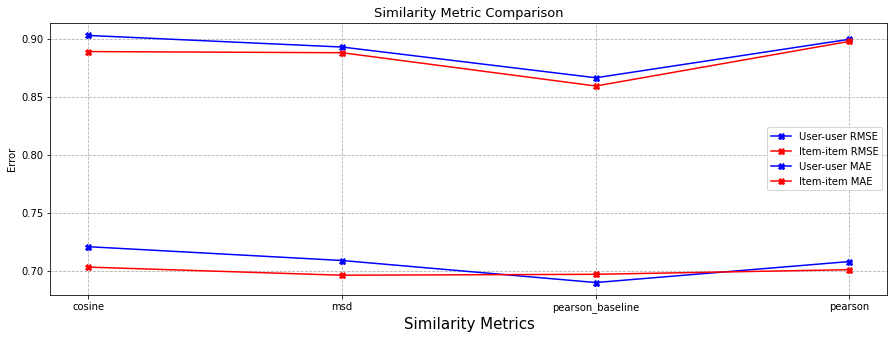

In [ ]:
SM = ['cosine', 'msd', 'pearson_baseline', 'pearson']

rmse1 = [0.9032, 0.8932, 0.8667, 0.8999]
rmse2 = [0.8893, 0.8883,0.8596, 0.8981 ]
mae1 = [0.7210, 0.7091, 0.6901, 0.7082]
mae2 = [0.7034, 0.6964,0.6972, 0.7012 ]

plt.figure(figsize=(15,5))
plt.title('Similarity Metric Comparison', loc='center', fontsize=13)
plt.plot(SM, rmse1, label='User-user RMSE', color='blue', marker='X')
plt.plot(SM, rmse2, label='Item-item RMSE', color='red', marker='X')
plt.xlabel('Similarity Metrics', fontsize=15)
plt.ylabel('Error', fontsize=10)
plt.plot(SM, mae1, label='User-user MAE', color='blue', marker='X')
plt.plot(SM, mae2, label='Item-item MAE', color='red', marker='X')
plt.legend()
plt.grid(ls='dashed')
plt.show()

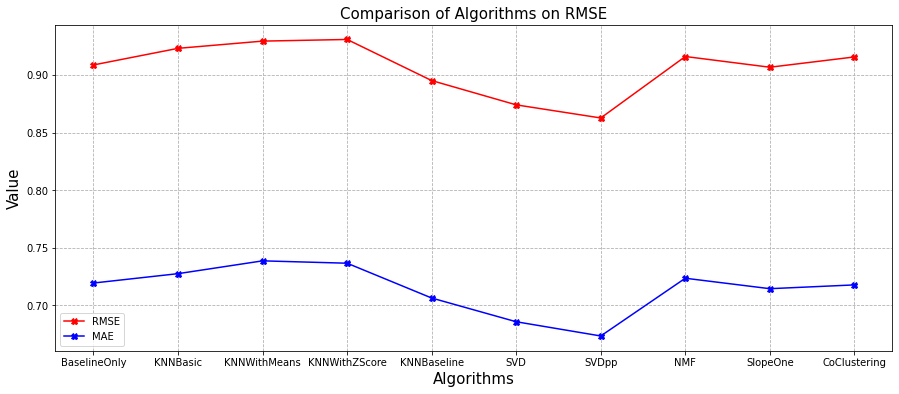

In [ ]:
Algo = ['BaselineOnly','KNNBasic', 'KNNWithMeans', 'KNNWithZScore','KNNBaseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering']
rmse = [0.908617, 0.923024, 0.929287, 0.930720,0.895069,0.873984,0.862614,0.915935, 0.906634,0.915561]
mae = [0.719422, 0.727552,0.738663,0.736607,0.706415,0.685826,0.673489,0.723579, 0.714510,0.717795]

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(Algo, rmse, label='RMSE', color='red', marker='X')
plt.plot(Algo, mae, label='MAE', color='blue', marker='X')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

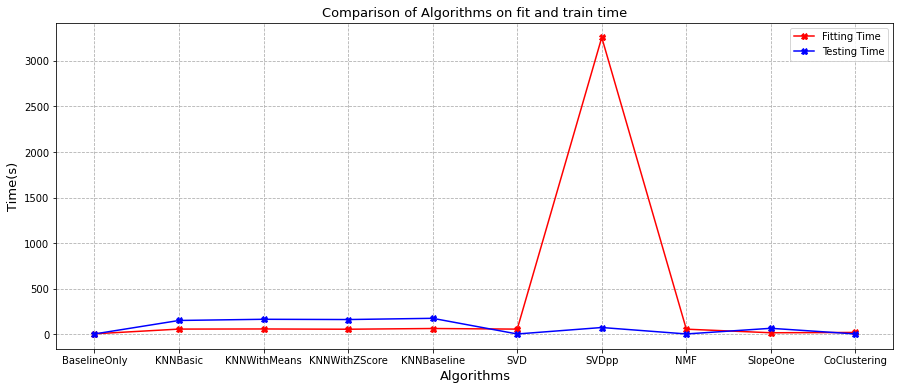

In [ ]:
fit_time = [4.586215, 56.279947, 57.593617,54.722606,62.627911,55.877482,3256.132195,55.372593,16.042697, 19.347667]
test_time = [2.908219, 150.852565, 163.850462,161.066698,174.428705,2.632710,73.504739,2.918873, 64.904856,2.986175 ]

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on fit and train time', loc='center', fontsize=13)
plt.plot(Algo, fit_time, label='Fitting Time', color='red', marker='X')
plt.plot(Algo, test_time, label='Testing Time', color='blue', marker='X')
plt.xlabel('Algorithms', fontsize=13)
plt.ylabel('Time(s)', fontsize=13)
plt.legend()
plt.grid(ls='dashed')
plt.show()

In [ ]:
def get_top_n(predictions, algo_weights, n):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    top_n_ndcg = defaultdict(list)
    for i in range(len(predictions)):
        row = predictions.iloc[i, :]
        final_est = algo_weights['svd']*float(row['svd_rating']) + algo_weights['knn']*float(row['knn_rating']) + \
                    algo_weights['svdpp']*float(row['svdpp_rating']) + algo_weights['slope']*float(row['slopeone_rating']) + \
                    algo_weights['baseline']*float(row['baseline_rating']) + algo_weights['nmf']*float(row['nmf_rating'])
        top_n[row[0]].append((row[1], final_est))
        top_n_ndcg[row[0]].append((row[1], row[2], final_est))
    
    print(len(top_n_ndcg[0]))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    for uid, user_ratings in top_n_ndcg.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n_ndcg[uid] = user_ratings[:n]

    return top_n, top_n_ndcg


def precision_recall_at_k(predictions, algo_weights, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for i in range(len(predictions)):
        row = predictions.iloc[i, :]
        final_est = algo_weights['svd']*float(row['svd_rating']) + algo_weights['knn']*float(row['knn_rating']) + \
                    algo_weights['svdpp']*float(row['svdpp_rating']) + algo_weights['slope']*float(row['slopeone_rating']) + \
                    algo_weights['baseline']*float(row['baseline_rating']) + algo_weights['nmf']*float(row['nmf_rating'])
        user_est_true[row[0]].append((final_est, row[2]))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k/n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k/n_rel if n_rel != 0 else 1

    return precisions, recalls


def dcg_at_k(scores):
    return scores[0] + sum(sc/math.log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores) + 1)))


def ndcg_at_k(predicted_scores, actual_scores):
    idcg = dcg_at_k(sorted(actual_scores, reverse=True))
    return (dcg_at_k(predicted_scores)/idcg) if idcg > 0.0 else 0.0


predictions = pd.read_csv("test_prediction.csv")
mean_value=predictions['nmf_rating'].mean()

predictions['nmf_rating'].fillna(value=mean_value, inplace=True)
#print(set(prediction['nmf_rating']))
print(len(predictions))
algo_weights = dict()
algo_weights['svd'] = 0
algo_weights['knn'] = 0.5
algo_weights['svdpp'] = 0.25
algo_weights['slope'] = 0
algo_weights['baseline'] = 0
algo_weights['nmf'] = 0.25
n = 5
threshold = 3.75
top_n, top_n_ndcg = get_top_n(predictions, algo_weights, n)
'''with open('top5_svdpp.csv', 'w', newline="") as csv_file:
    writer = csv.writer(csv_file)
    for key, value in top_n.items():
        writer.writerow([key, value])'''

ndcg_scores = dict()
print(len(top_n_ndcg.items()))
for uid, user_ratings in top_n_ndcg.items():
    true = []
    est = []
    for _, tru_r, est_r in user_ratings:
        true.append(tru_r)
        est.append(est_r)
        
    #print(sum(true),len(true),sum(est), len(est))
    ndcg = ndcg_at_k(est, true)
    #print(ndcg)
    ndcg_scores[uid] = ndcg

# Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

precisions, recalls = precision_recall_at_k(predictions, algo_weights, n, threshold)
precision = sum(prec for prec in precisions.values())/len(precisions)
recall = sum(rec for rec in recalls.values())/len(recalls)
fmeasure = (2*precision*recall)/(precision + recall)
print(sum(ndcg_scores.values()), len(ndcg_scores))
ndcg_score = sum(ndcg for ndcg in ndcg_scores.values())/len(ndcg_scores)
print("Precision: ", precision)
print("Recall: ", recall)
print("F-Measure", fmeasure)
print("NDCG Score: ", ndcg_score)

49235
1
49235
861.3129821436795 49235
Precision:  0.9982126536000813
Recall:  0.3734132223012085
F-Measure 0.5435094366059792
NDCG Score:  0.01749391656633857


In [ ]:
movies = pd.read_csv('movie_vector.csv')
print("Movie vector example : \n" + movies['movie_vector'][0],'\n')
users = pd.read_csv('user_info.csv')
print("User vector example : \n" + users['user_vector'][0])


Movie vector example : 
[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

User vector example : 
[4.38028169 4.68181818 4.48484848 4.25757576 4.24324324 4.28571429
 4.54545455 4.37662338 4.5        4.16666667 3.64285714 4.2
 4.3        4.6        4.64705882 0.         0.         4.33333333
 5.         0.        ]
